# 0. Import Library

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn: Data Splitting, Preprocessing, Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scikit-learn: Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Boosting Libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# SciPy: Optimization
from scipy.optimize import minimize

# PyTorch: Model Training and Utilities
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random
import numpy as np
import torch
import os

def set_seed(seed=42):
    random.seed(seed)                      
    np.random.seed(seed)                   
    torch.manual_seed(seed)                
    torch.cuda.manual_seed(seed)           
    torch.cuda.manual_seed_all(seed)       

    torch.backends.cudnn.deterministic = True  

    os.environ['PYTHONHASHSEED'] = str(seed)    

set_seed(42)
g = torch.Generator()

g.manual_seed(42)

# 1. Loda Data

In [254]:
df = pd.read_csv("chemical.csv")

X = df.drop(columns=['ECH_target'])
y = df['ECH_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Prediction Model

## 2-1. Other Prediction Models

▶ Tuning & Training LinearRegression


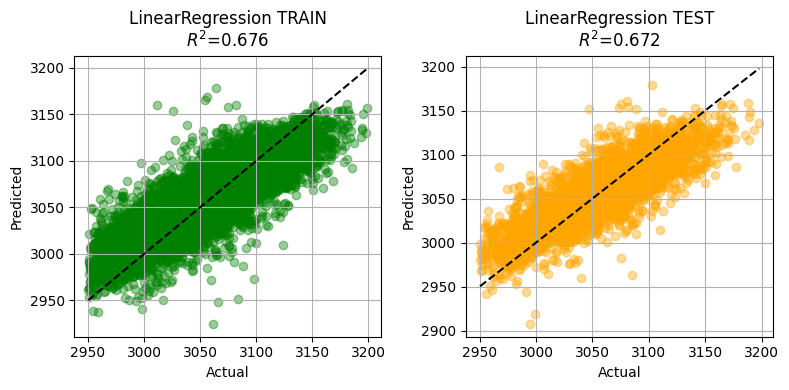

▶ Tuning & Training DecisionTree


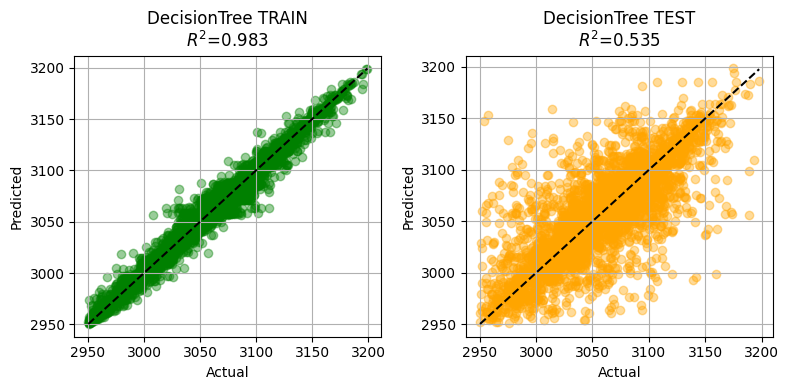

▶ Tuning & Training RandomForest


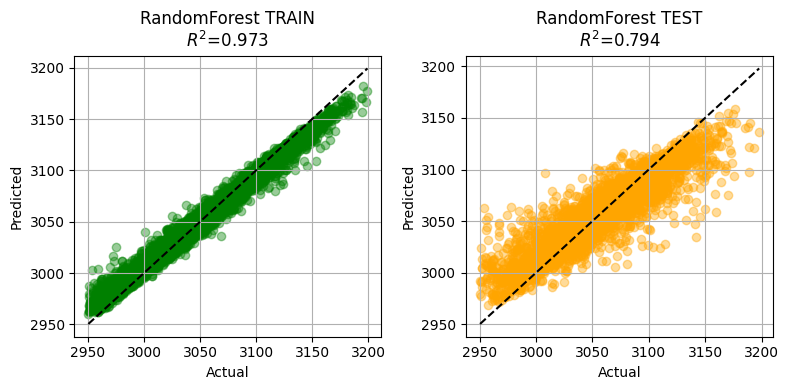

▶ Tuning & Training GradientBoosting


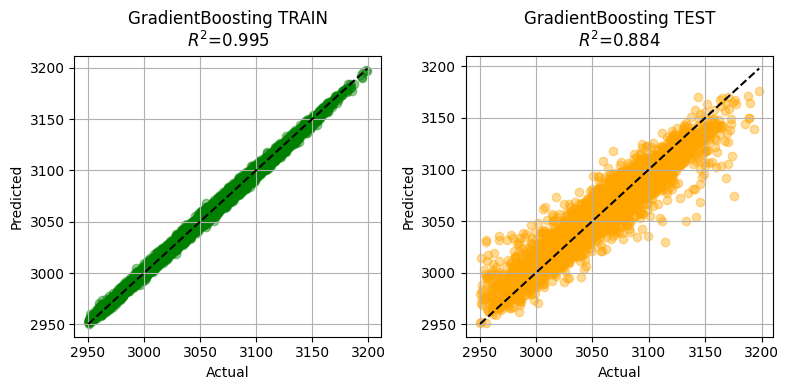

▶ Tuning & Training XGBoost
Traceback (most recent call last):
  File "/home/sjy990426/Desktop/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 426, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 108, in get
    if not self._rlock.acquire(block, timeout):
KeyboardInterrupt

Traceback (most recent call last):
  File "/home/sjy990426/Desktop/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 426, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 108, in get
    if not self._rlock.acquire(block, timeout):
KeyboardInterrupt

Traceback (most recent call last):
  File "/home/sjy990426/Desktop/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 426, in _process_worker
    call_item = call_queue.get(block=True, time

KeyboardInterrupt: 

In [344]:
# Re-import required modules after kernel reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# Load data
df = pd.read_csv("chemical.csv")

# Split data
X = df.drop(columns=['ECH_target'])
y = df['ECH_target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Preprocessing
num_cols = X.columns.tolist()
prep = ColumnTransformer([('scale', StandardScaler(), num_cols)])

# Define parameter grids for hyperparameter tuning
param_grids = {
    'DecisionTree': {
        'model__max_depth': [3, 5, 10, 20, 30],
        'model__min_samples_split': [2, 5, 7, 10]
    },
    'RandomForest': {
        'model__n_estimators': [500, 700, 1000],
        'model__max_depth': [3, 5, 10, 20, 30],
        'model__min_samples_split': [2, 5]
    },
    'GradientBoosting': {
        'model__n_estimators': [500, 700, 1000],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'model__n_estimators': [500, 700, 1000],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.6, 0.7, 0.8],
        'model__colsample_bytree': [0.6, 0.7, 0.8]
    }
}

# Define base models
base_models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
}

# Store results
results = []

# Perform training, tuning, and plotting
for name, model in base_models.items():
    print(f'▶ Tuning & Training {name}')
    pipe = Pipeline([('prep', prep), ('model', model)])
    
    if name in param_grids:
        search = GridSearchCV(pipe, param_grids[name], cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_
    else:
        pipe.fit(X_train, y_train)
        best_model = pipe
        best_params = 'Default'

    pred_tr = best_model.predict(X_train)
    pred_te = best_model.predict(X_test)

    results.append({
        'Model': name,
        'BestParams': best_params,
        'MAE_train': mean_absolute_error(y_train, pred_tr),
        'MAE_test':  mean_absolute_error(y_test,  pred_te),
        'RMSE_train': np.sqrt(mean_squared_error(y_train, pred_tr)),
        'RMSE_test':  np.sqrt(mean_squared_error(y_test,  pred_te)),
        'R2_train':   r2_score(y_train, pred_tr),
        'R2_test':    r2_score(y_test,  pred_te)
    })

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))  

    # Train
    axes[0].scatter(y_train, pred_tr, alpha=0.4, color='green')
    lims = [y_train.min(), y_train.max()]
    axes[0].plot(lims, lims, 'k--')
    axes[0].set_title(f'{name} TRAIN\n$R^2$={r2_score(y_train, pred_tr):.3f}')
    axes[0].set_xlabel('Actual')
    axes[0].set_ylabel('Predicted')

    # Test
    axes[1].scatter(y_test, pred_te, alpha=0.4, color='orange')
    lims = [y_test.min(), y_test.max()]
    axes[1].plot(lims, lims, 'k--')
    axes[1].set_title(f'{name} TEST\n$R^2$={r2_score(y_test, pred_te):.3f}')
    axes[1].set_xlabel('Actual')
    axes[1].set_ylabel('Predicted')

    plt.tight_layout()
    plt.show()

# Display final result summary
results_df = pd.DataFrame(results).sort_values('MAE_test')
results_df


In [7]:
results_df

,Model,MAE_train,MAE_test,RMSE_train,RMSE_test,R2_train,R2_test
4,XGBoost,1.881833,10.363944,2.453256,14.208592,0.996694,0.888240
3,GradientBoosting,2.278602,10.476020,2.909069,14.486354,0.995352,0.883827
2,RandomForest,4.933338,13.554152,6.979157,19.291681,0.973247,0.793972
0,LinearRegression,18.540064,18.587841,24.283732,24.332158,0.676106,0.672247
1,DecisionTree,3.324244,18.910738,5.588978,28.992917,0.982843,0.534661


## 2-2. Prediction Model -  Neural Network

Epoch    0 | train MSE 0.0121 | val MSE 0.0151
Epoch   20 | train MSE 0.0018 | val MSE 0.0035
Epoch   40 | train MSE 0.0018 | val MSE 0.0023
Epoch   60 | train MSE 0.0012 | val MSE 0.0021
Epoch   80 | train MSE 0.0005 | val MSE 0.0016
Epoch  100 | train MSE 0.0003 | val MSE 0.0016
Epoch  120 | train MSE 0.0002 | val MSE 0.0012
Epoch  140 | train MSE 0.0002 | val MSE 0.0012
Epoch  160 | train MSE 0.0000 | val MSE 0.0012
Epoch  180 | train MSE 0.0002 | val MSE 0.0012
Epoch  200 | train MSE 0.0001 | val MSE 0.0012
Epoch  220 | train MSE 0.0001 | val MSE 0.0012
Epoch  240 | train MSE 0.0001 | val MSE 0.0012
Epoch  260 | train MSE 0.0001 | val MSE 0.0012
Early stop @ 274 | best val MSE 0.0012

Train R²: 0.9968 | Test R²: 0.9596


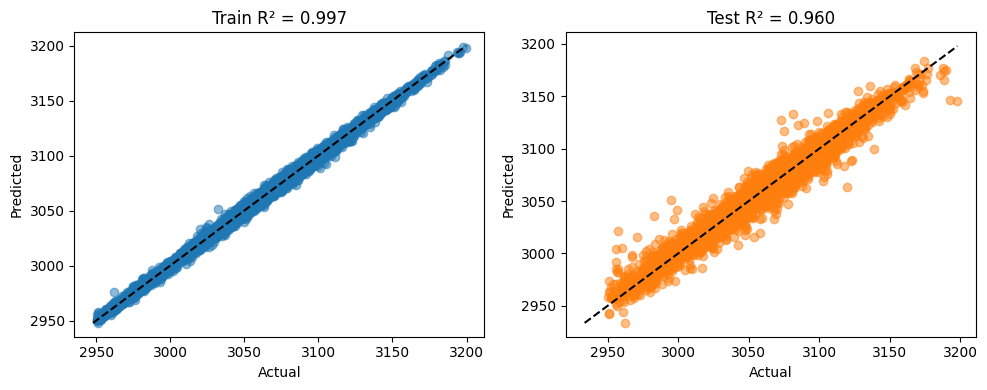

In [345]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim  
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test) 

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True,generator=g)


device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Net(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 1),
        )
    def forward(self, x): return self.net(x)

model = Net(X_train_t.shape[1]).to(device)
crit = nn.MSELoss()
opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
sched = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=10) # patience 조정

best_val, wait, patience = float('inf'), 0, 30 

for epoch in range(1000): 
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_t.to(device))
        val_loss = crit(val_pred, y_test_t.to(device)).item()
    sched.step(val_loss)

    if val_loss < best_val:
        best_val, wait = val_loss, 0
        torch.save(model.state_dict(), 'best_nn.pt')
    else:
        wait += 1
        if wait > patience:
            print(f'Early stop @ {epoch} | best val MSE {best_val:.4f}')
            break

    if epoch % 20 == 0:
        print(f'Epoch {epoch:4d} | train MSE {loss.item():.4f} | val MSE {val_loss:.4f}')

model.load_state_dict(torch.load('best_nn.pt'))
model.eval()
with torch.no_grad():
    y_train_pred_scaled = model(X_train_t.to(device)).cpu().numpy()
    y_test_pred_scaled = model(X_test_t.to(device)).cpu().numpy()

    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled).ravel()
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled).ravel()

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test,  y_test_pred)

print(f'\nTrain R²: {train_r2:.4f} | Test R²: {test_r2:.4f}')


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5, color='tab:blue')
lims = [min(y_train.min(), y_train_pred.min()), max(y_train.max(), y_train_pred.max())]
plt.plot(lims, lims, 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Train R² = {train_r2:.3f}')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5,  color='tab:orange')
lims = [min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())]
plt.plot(lims, lims, 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Test R² = {test_r2:.3f}')
plt.grid()

plt.tight_layout()
plt.show()

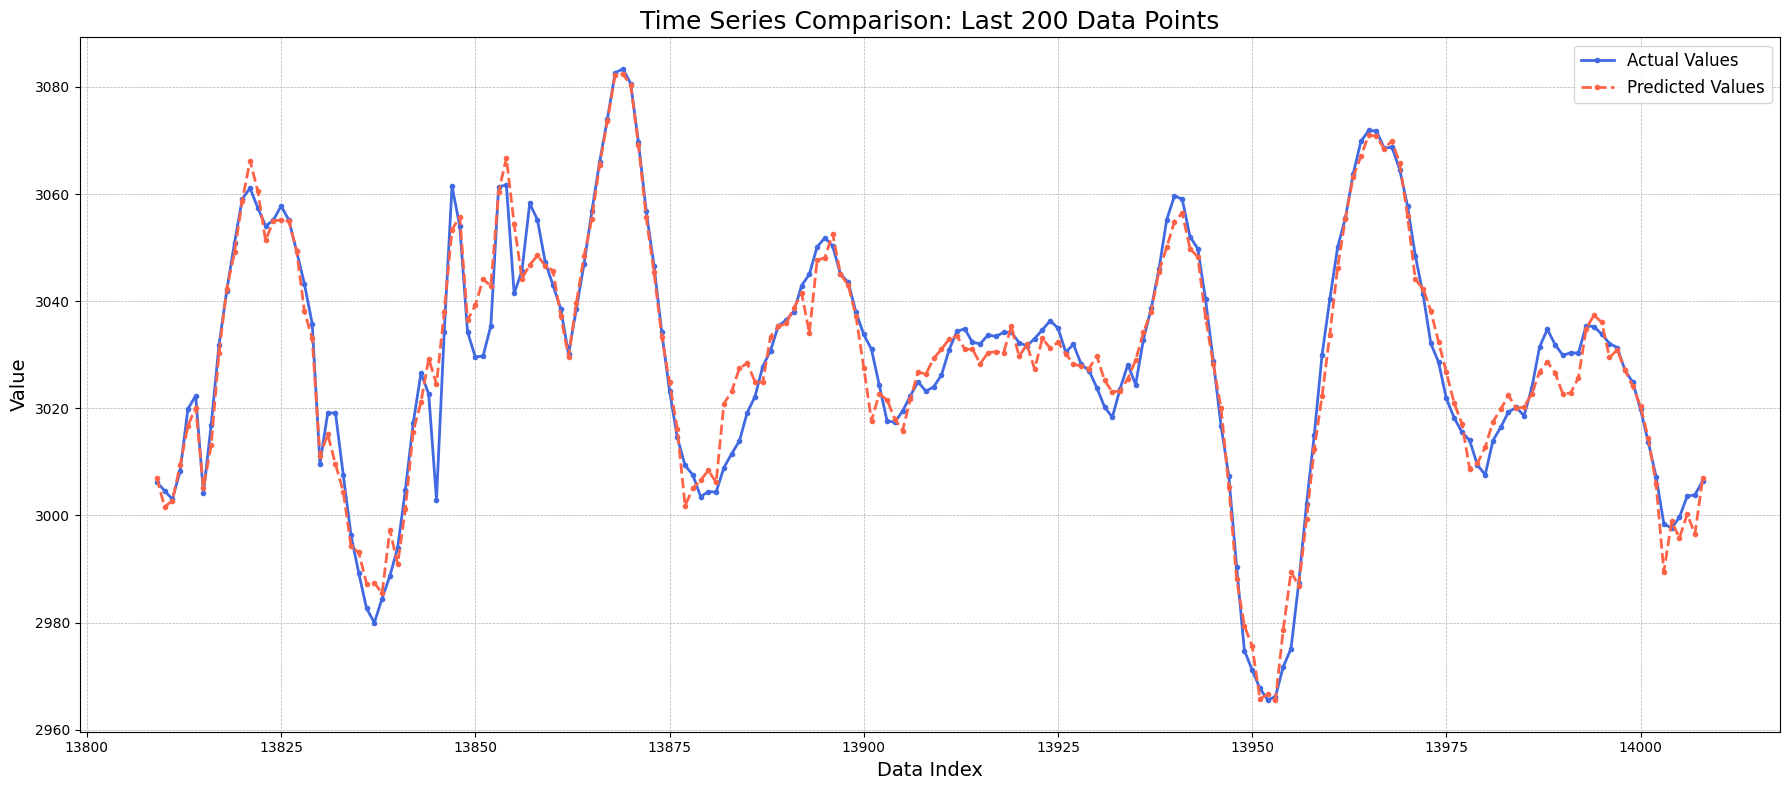


--- Prediction vs Actual (Last 200 Points) ---
            Actual    Predicted
13999  3024.844357  3024.087891
14000  3019.780415  3020.353027
14001  3013.653112  3014.378418
14002  3007.229668  3005.799561
14003  2998.421245  2989.525635
14004  2997.620083  2998.866455
14005  2999.650581  2995.773926
14006  3003.581037  3000.225586
14007  3003.849461  2996.532471
14008  3006.410622  3007.016113


In [309]:

num_predictions = 200
X_to_predict = X.tail(num_predictions)
y_actual = y.tail(num_predictions)


prediction_model = model
prediction_model.eval() 


X_to_predict_scaled = x_scaler.transform(X_to_predict)
X_to_predict_t = torch.tensor(X_to_predict_scaled, dtype=torch.float32).to(device)


with torch.no_grad(): 
    y_pred_scaled = prediction_model(X_to_predict_t)


y_pred_scaled_np = y_pred_scaled.cpu().numpy()
y_predicted = y_scaler.inverse_transform(y_pred_scaled_np).ravel()


plt.figure(figsize=(18, 8))

plt.plot(y_actual.index, y_actual.values, label='Actual Values', color='royalblue', marker='.', linestyle='-', linewidth=2)
plt.plot(y_actual.index, y_predicted, label='Predicted Values', color='tomato', marker='.', linestyle='--', linewidth=2)

plt.title(f'Time Series Comparison: Last {num_predictions} Data Points', fontsize=18)
plt.xlabel('Data Index', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

comparison_df = pd.DataFrame({
    'Actual': y_actual.values,
    'Predicted': y_predicted
}, index=y_actual.index)

print("\n--- Prediction vs Actual (Last 200 Points) ---")
print(comparison_df.tail(10))

## 2-3. Prediction Model -  Neural Network with pattern matching

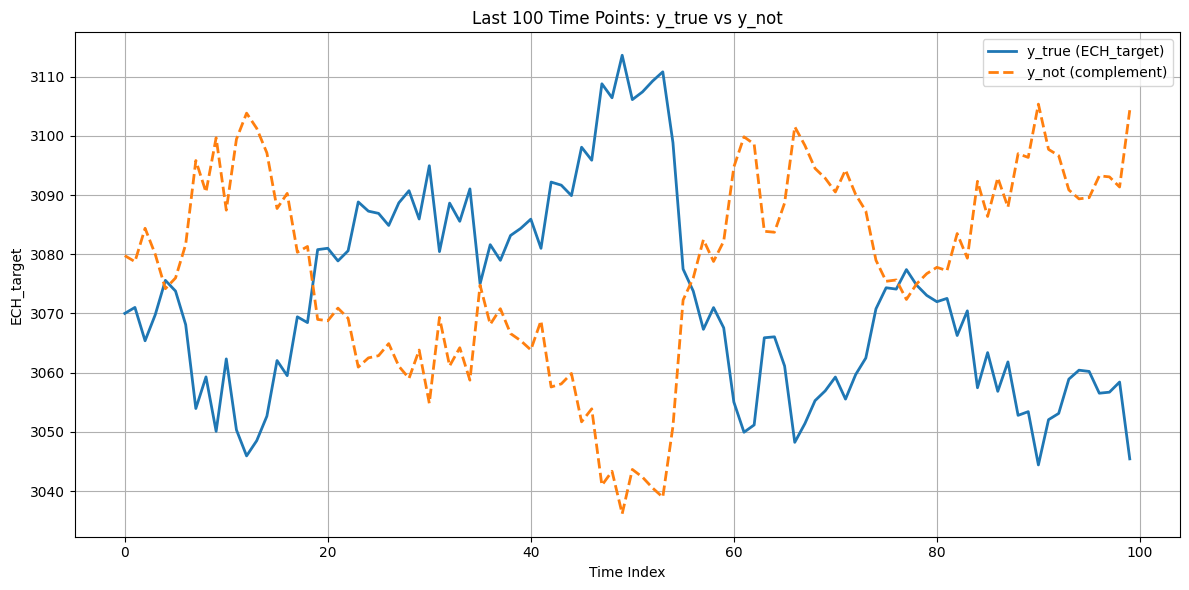

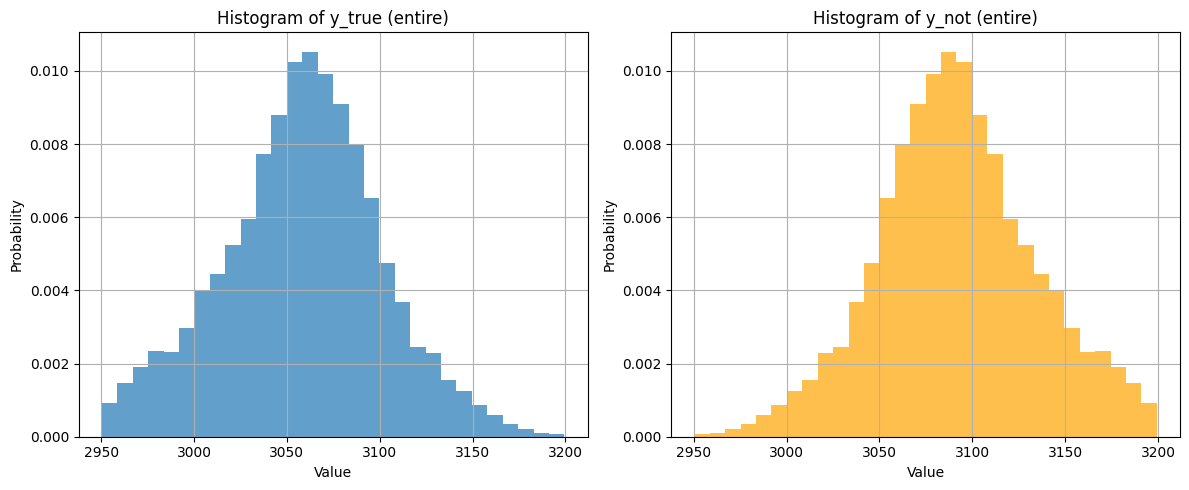

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


y_true = df['ECH_target'].values
y_max, y_min = np.max(y_true), np.min(y_true)
y_not = y_max + y_min - y_true

# Time series plot for last 100
plt.figure(figsize=(12, 6))
plt.plot(range(100), y_true[:100], label='y_true (ECH_target)', linewidth=2)
plt.plot(range(100), y_not[:100],
         label='y_not (complement)', linewidth=2, linestyle='--')
plt.title('Last 100 Time Points: y_true vs y_not')
plt.xlabel('Time Index')
plt.ylabel('ECH_target')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram plot for entire data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(y_true, bins=30, density=True, alpha=0.7, label='y_true')
plt.title('Histogram of y_true (entire)')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(y_not, bins=30, density=True, alpha=0.7,
         label='y_not', color='orange')
plt.title('Histogram of y_not (entire)')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.grid(True)

plt.tight_layout()
plt.show()

--- Start Training for best_pmc_model.pt ---
Epoch    0 | train loss 0.0949 | val loss 0.1576
Epoch   20 | train loss 0.1024 | val loss 0.0563
Epoch   40 | train loss 0.0068 | val loss 0.0341
Epoch   60 | train loss 0.0091 | val loss 0.0564
Epoch   80 | train loss 0.0025 | val loss 0.0213
Epoch  100 | train loss 0.0118 | val loss 0.0182
Epoch  120 | train loss 0.0093 | val loss 0.0156
Epoch  140 | train loss 0.0062 | val loss 0.0151
Epoch  160 | train loss 0.0224 | val loss 0.0139
Epoch  180 | train loss 0.0044 | val loss 0.0130
Epoch  200 | train loss 0.0020 | val loss 0.0130
Epoch  220 | train loss 0.0015 | val loss 0.0126
Epoch  240 | train loss 0.0029 | val loss 0.0126
Epoch  260 | train loss 0.0013 | val loss 0.0126
Early stop @ 280 | best val loss 0.0124
--- Finished Training. Best model saved to best_pmc_model.pt ---

--- Evaluation for PMC Regression Model ---
Train R²: 0.9900 | Test R²: 0.9528


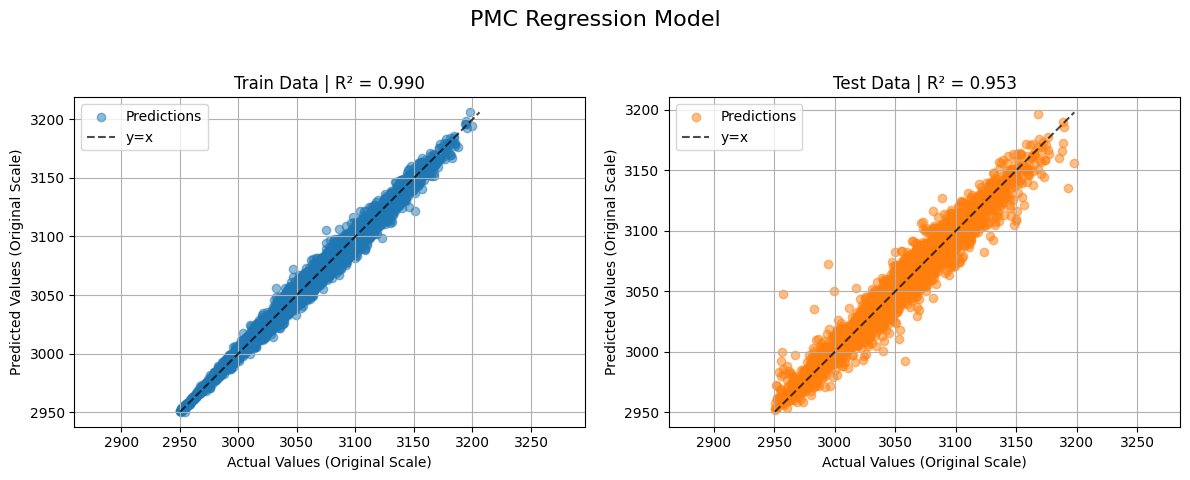

In [327]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 1),
        )
    def forward(self, x): return self.net(x)

def to_prob_dist(x, eps=1e-8):
    x_shift = x - torch.min(x) + eps
    return x_shift / (x_shift.sum() + eps)

def js_div(p, q, eps=1e-8):
    p_prob = to_prob_dist(p)
    q_prob = to_prob_dist(q)
    m = 0.5 * (p_prob + q_prob)
    kl_pm = torch.sum(p_prob * torch.log((p_prob + eps) / (m + eps)))
    kl_qm = torch.sum(q_prob * torch.log((q_prob + eps) / (m + eps)))
    return 0.5 * (kl_pm + kl_qm)

def custom_loss(y_pred, y_true, lam=0.5):
    mse = nn.MSELoss()(y_pred, y_true)
    y_max, y_min = y_true.max(), y_true.min()
    y_not = y_max + y_min - y_true
    D_js_y_yhat = js_div(y_true.view(-1), y_pred.view(-1))
    D_js_y_ynot = js_div(y_true.view(-1), y_not.view(-1))
    pmc_term = D_js_y_yhat / (D_js_y_ynot + 1e-8)
    return mse + lam * pmc_term

def train_pmc_model(X_train, y_train, X_test, y_test, model_save_path, lam_value=1.0, epochs=500, patience=30):
   
    x_scaler = StandardScaler()
    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled = x_scaler.transform(X_test) 

    y_scaler = MinMaxScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

    X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)
    X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = Net(X_train_t.shape[1]).to(device)
    opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=10)

    best_val, wait = float('inf'), 0
    print(f"--- Start Training for {model_save_path} ---")
    for epoch in range(epochs): 
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            pred = model(xb)
            loss = custom_loss(pred, yb, lam=lam_value)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_test_t.to(device))
            val_loss = custom_loss(val_pred, y_test_t.to(device), lam=lam_value).item()
        sched.step(val_loss)

        if val_loss < best_val:
            best_val, wait = val_loss, 0
            torch.save(model.state_dict(), model_save_path)
        else:
            wait += 1
            if wait > patience:
                print(f'Early stop @ {epoch} | best val loss {best_val:.4f}')
                break

        if epoch % 20 == 0:
            print(f'Epoch {epoch:4d} | train loss {loss.item():.4f} | val loss {val_loss:.4f}')
    
    print(f"--- Finished Training. Best model saved to {model_save_path} ---")
    model.load_state_dict(torch.load(model_save_path))
    return model, x_scaler, y_scaler

def evaluate_pmc_model(model, x_scaler, y_scaler, X_train, y_train, X_test, y_test, title="PMC Model"):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    X_train_t = torch.tensor(x_scaler.transform(X_train), dtype=torch.float32).to(device)
    X_test_t = torch.tensor(x_scaler.transform(X_test), dtype=torch.float32).to(device)

    with torch.no_grad():
        y_train_pred_scaled = model(X_train_t).cpu().numpy()
        y_test_pred_scaled = model(X_test_t).cpu().numpy()

    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled).ravel()
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled).ravel()

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    print(f'\n--- Evaluation for {title} ---')
    print(f'Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}')

    plt.figure(figsize=(12, 5))
    plt.suptitle(title, fontsize=16)

    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5, color='tab:blue', label='Predictions')
    lims = [min(y_train.min(), y_train_pred.min()), max(y_train.max(), y_train_pred.max())]
    plt.plot(lims, lims, 'k--', alpha=0.7, label='y=x')
    plt.xlabel('Actual Values (Original Scale)'); plt.ylabel('Predicted Values (Original Scale)')
    plt.title(f'Train Data | R² = {train_r2:.3f}'); plt.grid(True); plt.legend(); plt.axis('equal'); plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5, color='tab:orange', label='Predictions')
    lims = [min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())]
    plt.plot(lims, lims, 'k--', alpha=0.7, label='y=x')
    plt.xlabel('Actual Values (Original Scale)'); plt.ylabel('Predicted Values (Original Scale)')
    plt.title(f'Test Data | R² = {test_r2:.3f}'); plt.grid(True); plt.legend(); plt.axis('equal'); plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()


pmc_model, x_scaler_pmc, y_scaler_pmc = train_pmc_model(
        X_train, y_train, X_test, y_test, 
        model_save_path='best_pmc_model.pt', 
        lam_value=0.6
    )

evaluate_pmc_model(
        pmc_model, x_scaler_pmc, y_scaler_pmc, 
        X_train, y_train, X_test, y_test, 
        title="PMC Regression Model"
    )

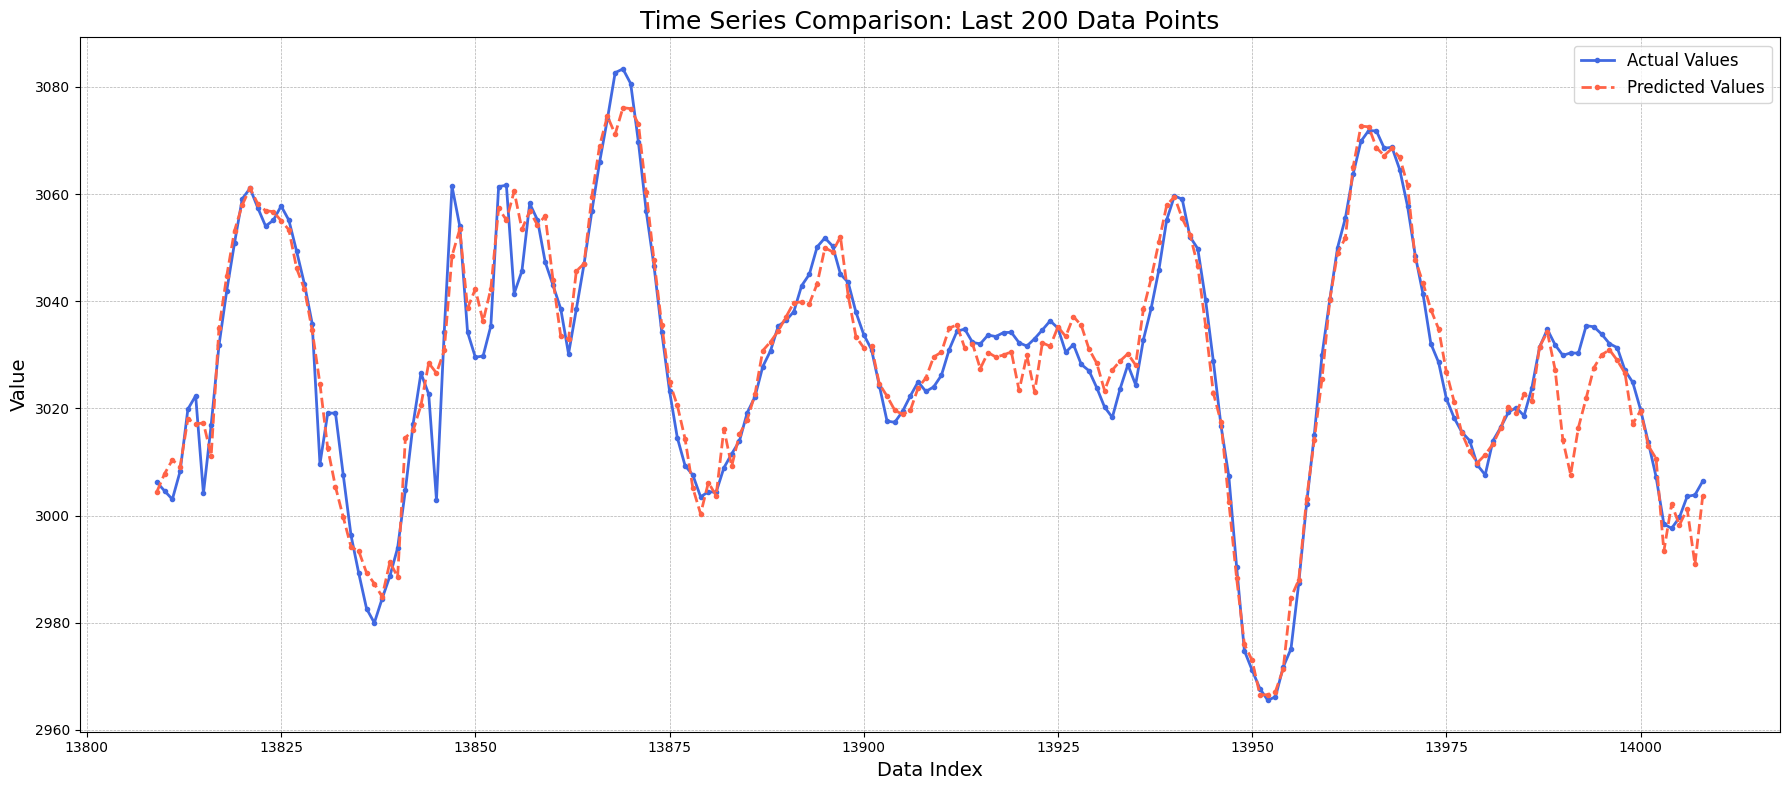


--- Prediction vs Actual (Last 200 Points) ---
            Actual    Predicted
13999  3024.844357  3017.110107
14000  3019.780415  3019.597656
14001  3013.653112  3013.041992
14002  3007.229668  3010.639404
14003  2998.421245  2993.348145
14004  2997.620083  3002.187256
14005  2999.650581  2998.218262
14006  3003.581037  3001.248779
14007  3003.849461  2990.914795
14008  3006.410622  3003.624268


In [334]:
num_predictions = 200
X_to_predict = X.tail(num_predictions)
y_actual = y.tail(num_predictions)

prediction_model = pmc_model
prediction_model.eval() 

X_to_predict_scaled = x_scaler_pmc.transform(X_to_predict)
X_to_predict_t = torch.tensor(X_to_predict_scaled, dtype=torch.float32).to(device)

with torch.no_grad(): 
    y_pred_scaled = prediction_model(X_to_predict_t)

y_pred_scaled_np = y_pred_scaled.cpu().numpy()
y_predicted = y_scaler_pmc.inverse_transform(y_pred_scaled_np).ravel()


plt.figure(figsize=(18, 8))

plt.plot(y_actual.index, y_actual.values, label='Actual Values', color='royalblue', marker='.', linestyle='-', linewidth=2)
plt.plot(y_actual.index, y_predicted, label='Predicted Values', color='tomato', marker='.', linestyle='--', linewidth=2)

plt.title(f'Time Series Comparison: Last {num_predictions} Data Points', fontsize=18)
plt.xlabel('Data Index', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

comparison_df = pd.DataFrame({
    'Actual': y_actual.values,
    'Predicted': y_predicted
}, index=y_actual.index)

print("\n--- Prediction vs Actual (Last 200 Points) ---")
print(comparison_df.tail(10))

# 3. Optimize the control values to maximize the ECH product

In [271]:
df = pd.read_csv("chemical.csv")
X_all = df.drop(columns=["ECH_target"])
y_all = df["ECH_target"].reset_index(drop=True)

df_ctrl = pd.read_csv("chemical_control_features.csv")

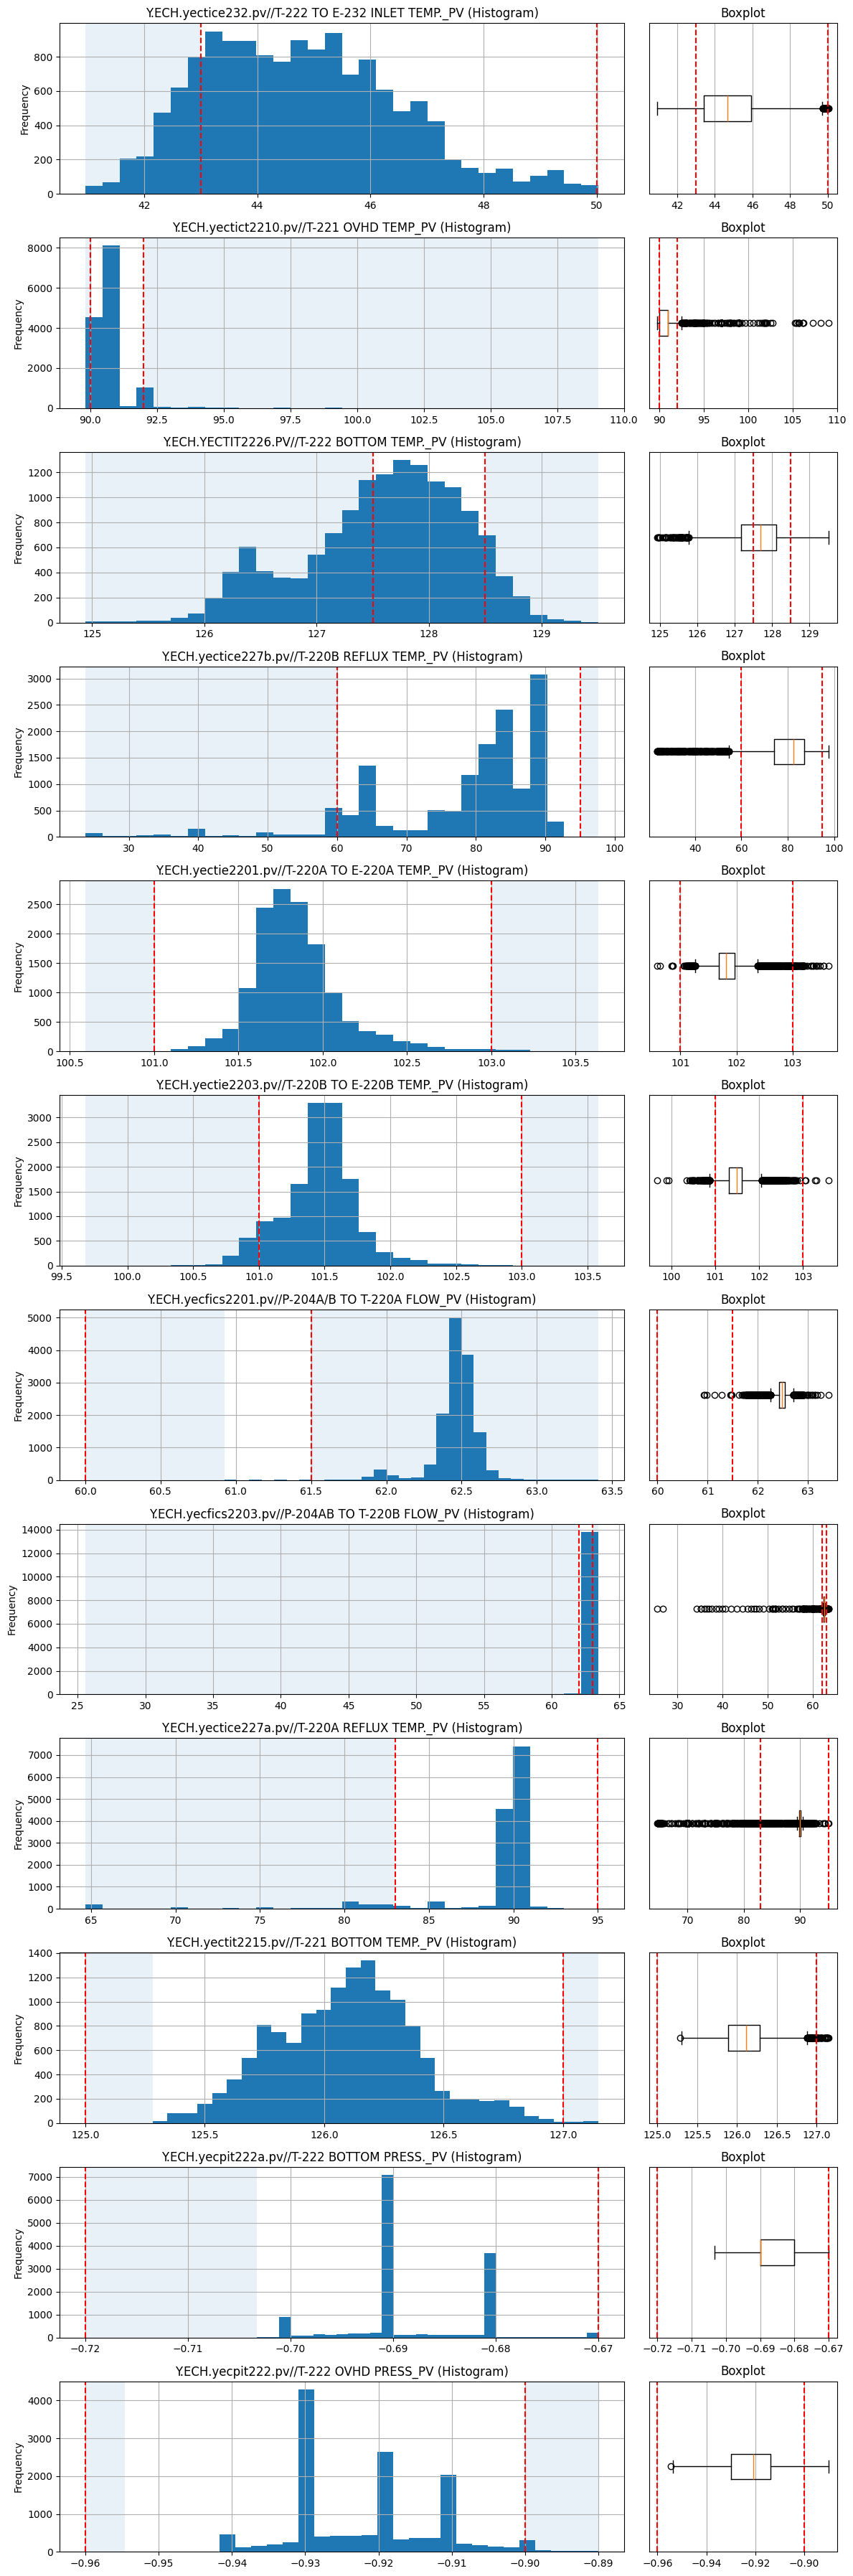

In [176]:
summary_rows = []
for _, row in df_ctrl.iterrows():
    tag = row["tag"]
    min_val, max_val = row["min"], row["max"]
    series = df[tag]

    below_min = (series < min_val).sum()
    above_max = (series > max_val).sum()
    total = len(series)
    in_range = total - below_min - above_max

    summary_rows.append(
        {
            "Tag": tag,
            "Below Min": below_min,
            "Above Max": above_max,
            "In Range": in_range,
            "Total": total,
        }
    )

plt.rcParams.update({"axes.grid": True})

fig_rows = len(df_ctrl)
fig, axes = plt.subplots(
    nrows=fig_rows, ncols=2, figsize=(12, 3 * fig_rows), gridspec_kw={"width_ratios": [3, 1]}
)

for idx, row in df_ctrl.iterrows():
    tag = row["tag"]
    min_val, max_val = row["min"], row["max"]
    series = df[tag]

    ax_hist = axes[idx, 0]
    ax_hist.hist(series, bins=30)
    ax_hist.axvline(min_val, color="red", linestyle="--")
    ax_hist.axvline(max_val, color="red", linestyle="--")
    ax_hist.set_title(f"{tag} (Histogram)")

    ax_hist.axvspan(series.min(), min_val, alpha=0.1)
    ax_hist.axvspan(max_val, series.max(), alpha=0.1)
    ax_hist.set_ylabel("Frequency")

    ax_box = axes[idx, 1]
    ax_box.boxplot(series, vert=False)
    ax_box.axvline(min_val, color="red", linestyle="--")
    ax_box.axvline(max_val, color="red", linestyle="--")
    ax_box.set_title("Boxplot")
    ax_box.set_yticks([])

plt.tight_layout()
plt.show()

summary_df = pd.DataFrame(summary_rows)

## Optimized 30% variables



In [330]:
import pandas as pd
import numpy as np
import torch
from scipy.optimize import minimize

df = pd.read_csv("chemical.csv")
X_all = df.drop(columns=["ECH_target"])
y_all = df["ECH_target"].reset_index(drop=True)

df_ctrl = pd.read_csv("chemical_control_features.csv")
control_tags = df_ctrl['tag'].tolist()
control_indices = [tag for tag in X_all.columns if tag in control_tags]
bounds = [tuple(df_ctrl[df_ctrl['tag'] == tag][['min', 'max']].values[0])
          for tag in control_indices]
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
pmc_model.eval()


total_len = len(X_all)
start_index = int(total_len * 0.7)

print(f"Starting optimization for the last 30% of data (index {start_index} to {total_len - 1})...")

optimized_preds = []
optimized_controls = []

for i in range(start_index, total_len):
    env_row = X_all.iloc[i].copy()
    
    def objective(control_vals):
        x_input = env_row.copy()
        for j, tag in enumerate(control_indices):
            x_input[tag] = control_vals[j]

        x_scaled = x_scaler_pmc.transform(pd.DataFrame([x_input]))
        x_tensor = torch.tensor(x_scaled, dtype=torch.float32).to(device)

        with torch.no_grad():
            scaled_pred = pmc_model(x_tensor).cpu().item()
            
        original_scale_pred = y_scaler_pmc.inverse_transform([[scaled_pred]])[0, 0]
        
        return -original_scale_pred
        
    x0 = np.array([env_row[tag] for tag in control_indices])
    res = minimize(objective, x0=x0, bounds=bounds, method='L-BFGS-B')
    
    final_optimized_pred = -res.fun 
    
    optimized_preds.append(final_optimized_pred)
    optimized_controls.append(res.x)

    if (i - start_index + 1) % 100 == 0:
        processed_count = i - start_index + 1
        total_to_process = total_len - start_index
        print(f"[{processed_count}/{total_to_process}] processed...")

print("\nOptimization for the last 30% is complete.")

df_optimized_results = pd.DataFrame({
    'Optimized_Yield': optimized_preds
})

df_optimized_controls = pd.DataFrame(
    data=optimized_controls,
    columns=control_indices
)

print("\nOptimized Results (last 30%):")
print(df_optimized_results.head())
print("\nOptimized Controls (last 30%):")
print(df_optimized_controls.head())

Starting optimization for the last 30% of data (index 9806 to 14008)...
[100/4203] processed...
[200/4203] processed...
[300/4203] processed...
[400/4203] processed...
[500/4203] processed...
[600/4203] processed...
[700/4203] processed...
[800/4203] processed...
[900/4203] processed...
[1000/4203] processed...
[1100/4203] processed...
[1200/4203] processed...
[1300/4203] processed...
[1400/4203] processed...
[1500/4203] processed...
[1600/4203] processed...
[1700/4203] processed...
[1800/4203] processed...
[1900/4203] processed...
[2000/4203] processed...
[2100/4203] processed...
[2200/4203] processed...
[2300/4203] processed...
[2400/4203] processed...
[2500/4203] processed...
[2600/4203] processed...
[2700/4203] processed...
[2800/4203] processed...
[2900/4203] processed...
[3000/4203] processed...
[3100/4203] processed...
[3200/4203] processed...
[3300/4203] processed...
[3400/4203] processed...
[3500/4203] processed...
[3600/4203] processed...
[3700/4203] processed...
[3800/4203] 

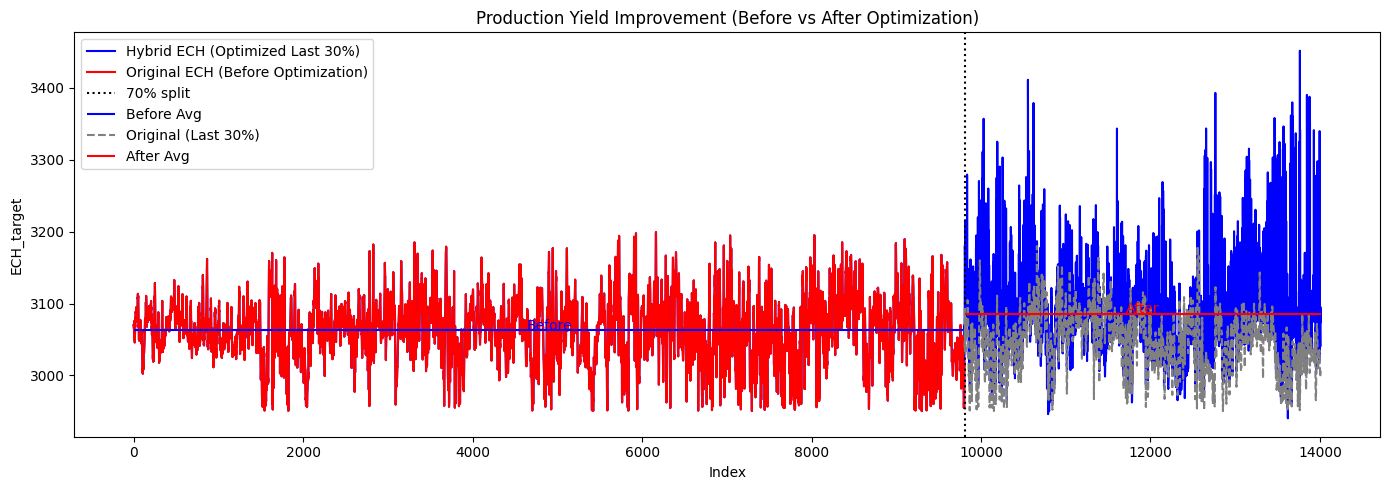

In [336]:
split_idx = int(0.7 * len(X_all))

original_series = y_all[:split_idx]
hybrid_series = np.concatenate([
    y_all[:split_idx],
    np.array(optimized_preds)
])
original_tail = y_all[split_idx:]
mean_before = np.mean(y_all[:split_idx])
mean_after = np.mean(optimized_preds)

plt.figure(figsize=(14, 5))
plt.plot(hybrid_series, label="Hybrid ECH (Optimized Last 30%)", color='blue')
plt.plot(original_series, label="Original ECH (Before Optimization)", color='red')
plt.axvline(split_idx, color='black', linestyle=':', label="70% split")
plt.hlines(mean_before, 0, split_idx, color='blue',
           linestyle='-', label="Before Avg")

plt.plot(np.arange(split_idx, len(y_all)), original_tail, label="Original (Last 30%)", color='gray', linestyle='--')

plt.hlines(mean_after, split_idx, len(y_all),
           color='red', linestyle='-', label="After Avg")
plt.text(split_idx / 2, mean_before + 0.3, 'Before', color='blue', ha='center')
plt.text(split_idx + (len(y_all) - split_idx)/2,
         mean_after + 0.3, 'After', color='red', ha='center')
plt.title("Production Yield Improvement (Before vs After Optimization)")
plt.xlabel("Index")
plt.ylabel("ECH_target")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [333]:
import numpy as np


mean_original = np.mean(y_all[split_idx:])
mean_optimized = np.mean(optimized_preds)

absolute_improvement = mean_optimized - mean_original
percentage_improvement = (absolute_improvement / mean_original) * 100

print("\n--- Comparison Before vs. After Full Data Optimization ---")
print(f"Original Average: {mean_original:.4f}")
print(f"Optimized Average: {mean_optimized:.4f}")
print(f"Absolute Improvement: {absolute_improvement:+.4f}")
print(f"Improvement Rate: {percentage_improvement:+.2f}%")


--- Comparison Before vs. After Full Data Optimization ---
Original Average: 3047.7031
Optimized Average: 3086.1186
Absolute Improvement: +38.4154
Improvement Rate: +1.26%


## Optimized all variables



In [337]:
import pandas as pd
import numpy as np
import torch
from scipy.optimize import minimize

df = pd.read_csv("chemical.csv")
X_all = df.drop(columns=["ECH_target"])
y_all = df["ECH_target"].reset_index(drop=True)

df_ctrl = pd.read_csv("chemical_control_features.csv")
control_tags = df_ctrl['tag'].tolist()
control_indices = [tag for tag in X_all.columns if tag in control_tags]
bounds = [tuple(df_ctrl[df_ctrl['tag'] == tag][['min', 'max']].values[0])
          for tag in control_indices]
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
pmc_model.eval()


total_len = len(X_all)

print(f"Starting optimization for all {total_len} data points...")

optimized_preds = []
optimized_controls = []

for i in range(total_len):
    env_row = X_all.iloc[i].copy()
    
    def objective(control_vals):
        x_input = env_row.copy()
        for j, tag in enumerate(control_indices):
            x_input[tag] = control_vals[j]

        x_scaled = x_scaler_pmc.transform(pd.DataFrame([x_input]))
        x_tensor = torch.tensor(x_scaled, dtype=torch.float32).to(device)

        with torch.no_grad():
            scaled_pred = pmc_model(x_tensor).cpu().item()
            
        original_scale_pred = y_scaler_pmc.inverse_transform([[scaled_pred]])[0, 0]
        
        return -original_scale_pred
        
    x0 = np.array([env_row[tag] for tag in control_indices])
    res = minimize(objective, x0=x0, bounds=bounds, method='L-BFGS-B')
    
    final_optimized_pred = -res.fun 
    
    optimized_preds.append(final_optimized_pred)
    optimized_controls.append(res.x)

    if (i + 1) % 100 == 0:
        print(f"[{i + 1}/{total_len}] processed...")

print("\nOptimization for all data points is complete.")

df_optimized_results = pd.DataFrame({
    'Optimized_Yield': optimized_preds
})

df_optimized_controls = pd.DataFrame(
    data=optimized_controls,
    columns=control_indices
)

print("\nOptimized Results (Full Dataset):")
print(df_optimized_results.head())
print("\nOptimized Controls (Full Dataset):")
print(df_optimized_controls.head())

Starting optimization for all 14009 data points...
[100/14009] processed...
[200/14009] processed...
[300/14009] processed...
[400/14009] processed...
[500/14009] processed...
[600/14009] processed...
[700/14009] processed...
[800/14009] processed...
[900/14009] processed...
[1000/14009] processed...
[1100/14009] processed...
[1200/14009] processed...
[1300/14009] processed...
[1400/14009] processed...
[1500/14009] processed...
[1600/14009] processed...
[1700/14009] processed...
[1800/14009] processed...
[1900/14009] processed...
[2000/14009] processed...
[2100/14009] processed...
[2200/14009] processed...
[2300/14009] processed...
[2400/14009] processed...
[2500/14009] processed...
[2600/14009] processed...
[2700/14009] processed...
[2800/14009] processed...
[2900/14009] processed...
[3000/14009] processed...
[3100/14009] processed...
[3200/14009] processed...
[3300/14009] processed...
[3400/14009] processed...
[3500/14009] processed...
[3600/14009] processed...
[3700/14009] processed

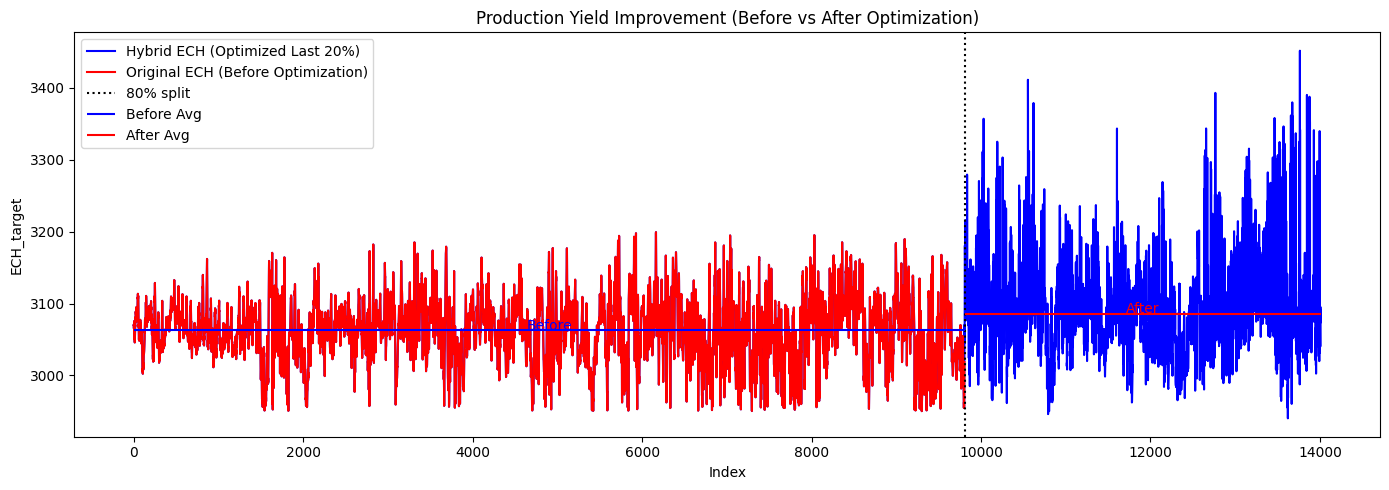

In [339]:
split_idx = int(0.7 * len(X_all))

original_series = y_all[:split_idx]
hybrid_series = np.concatenate([
    y_all[:split_idx],
    np.array(optimized_preds)[split_idx:]
])

mean_before = np.mean(y_all.values[:split_idx])
mean_after = np.mean(optimized_preds[split_idx:])

plt.figure(figsize=(14, 5))
plt.plot(hybrid_series, label="Hybrid ECH (Optimized Last 20%)", color='blue')
plt.plot(original_series, label="Original ECH (Before Optimization)", color='red')
plt.axvline(split_idx, color='black', linestyle=':', label="80% split")
plt.hlines(mean_before, 0, split_idx, color='blue',
           linestyle='-', label="Before Avg")
plt.hlines(mean_after, split_idx, len(y_all),
           color='red', linestyle='-', label="After Avg")
plt.text(split_idx / 2, mean_before + 0.3, 'Before', color='blue', ha='center')
plt.text(split_idx + (len(y_all) - split_idx)/2,
         mean_after + 0.3, 'After', color='red', ha='center')
plt.title("Production Yield Improvement (Before vs After Optimization)")
plt.xlabel("Index")
plt.ylabel("ECH_target")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [342]:
import numpy as np


mean_original = np.mean(y_all)
mean_optimized = np.mean(optimized_preds)

absolute_improvement = mean_optimized - mean_original
percentage_improvement = (absolute_improvement / mean_original) * 100

print("\n--- Comparison Before vs. After Full Data Optimization ---")
print(f"Original Average: {mean_original:.4f}")
print(f"Optimized Average: {mean_optimized:.4f}")
print(f"Absolute Improvement: {absolute_improvement:+.4f}")
print(f"Improvement Rate: {percentage_improvement:+.2f}%")


--- Comparison Before vs. After Full Data Optimization ---
Original Average: 3058.1838
Optimized Average: 3099.3000
Absolute Improvement: +41.1162
Improvement Rate: +1.34%


## Control variable after optimization


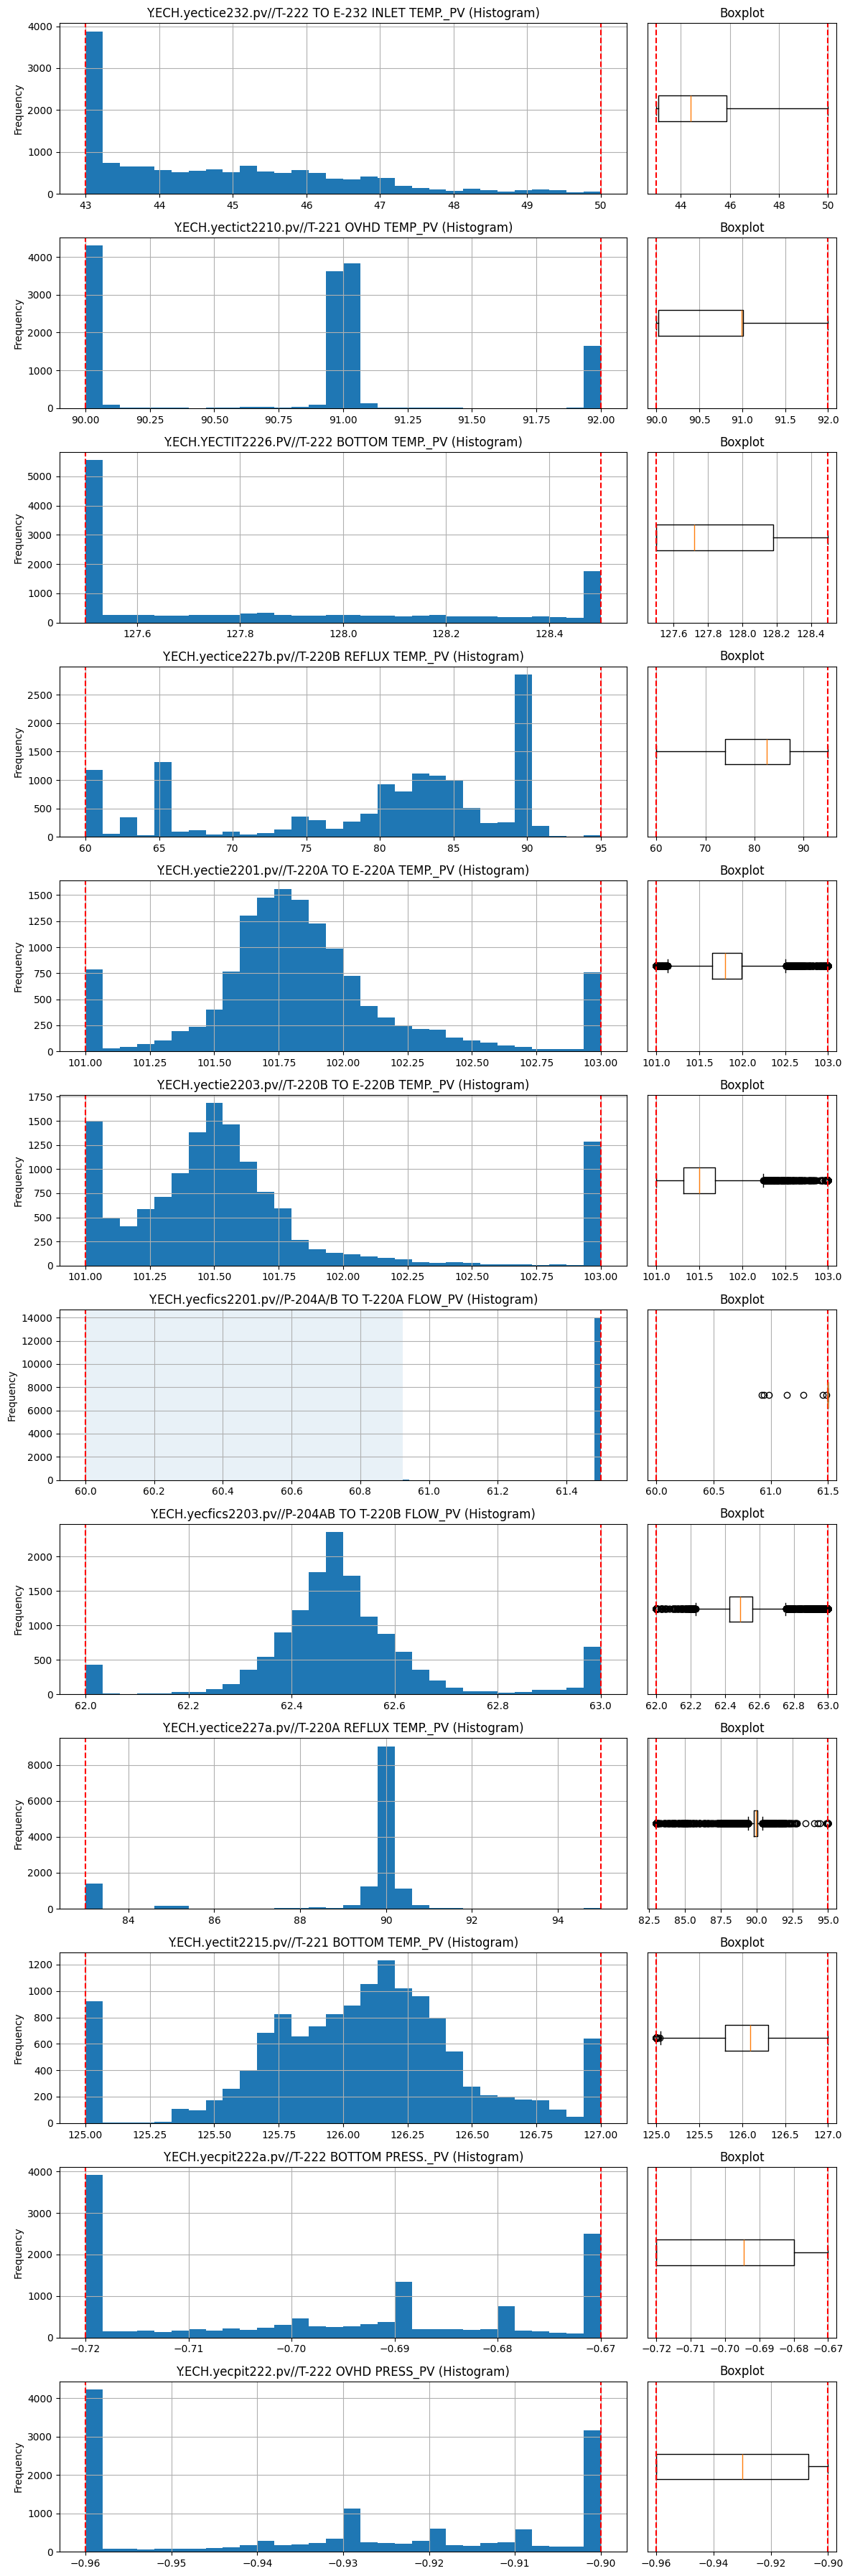

                                                  Tag  Below Min  Above Max  \
0   Y.ECH.yectice232.pv//T-222 TO E-232 INLET TEMP...          0          0   
1            Y.ECH.yectict2210.pv//T-221 OVHD TEMP_PV          0          0   
2          Y.ECH.YECTIT2226.PV//T-222 BOTTOM TEMP._PV          0          0   
3        Y.ECH.yectice227b.pv//T-220B REFLUX TEMP._PV          0          0   
4      Y.ECH.yectie2201.pv//T-220A TO E-220A TEMP._PV          0          0   
5      Y.ECH.yectie2203.pv//T-220B TO E-220B TEMP._PV          0          0   
6    Y.ECH.yecfics2201.pv//P-204A/B TO T-220A FLOW_PV          0          0   
7     Y.ECH.yecfics2203.pv//P-204AB TO T-220B FLOW_PV          0          0   
8        Y.ECH.yectice227a.pv//T-220A REFLUX TEMP._PV          0          0   
9          Y.ECH.yectit2215.pv//T-221 BOTTOM TEMP._PV          0          0   
10        Y.ECH.yecpit222a.pv//T-222 BOTTOM PRESS._PV          0          0   
11            Y.ECH.yecpit222.pv//T-222 OVHD PRESS_P

In [343]:
df_opt = df.copy()
for i, tag in enumerate(control_indices):
    df_opt[tag] = np.array(optimized_controls)[:, i]

summary_rows = []
fig, axes = plt.subplots(nrows=len(df_ctrl), ncols=2, figsize=(
    12, 3 * len(df_ctrl)), gridspec_kw={"width_ratios": [3, 1]})
plt.rcParams.update({"axes.grid": True})

for idx, row in df_ctrl.iterrows():
    tag = row["tag"]
    min_val, max_val = row["min"], row["max"]
    series = df_opt[tag]

    below = (series < min_val).sum()
    above = (series > max_val).sum()
    total = len(series)
    in_range = total - below - above

    summary_rows.append({
        "Tag": tag,
        "Below Min": below,
        "Above Max": above,
        "In Range": in_range,
        "Total": total
    })

    ax_hist = axes[idx, 0]
    ax_hist.hist(series, bins=30)
    ax_hist.axvline(min_val, color="red", linestyle="--")
    ax_hist.axvline(max_val, color="red", linestyle="--")
    ax_hist.set_title(f"{tag} (Histogram)")
    ax_hist.axvspan(series.min(), min_val, alpha=0.1)
    ax_hist.axvspan(max_val, series.max(), alpha=0.1)
    ax_hist.set_ylabel("Frequency")

    ax_box = axes[idx, 1]
    ax_box.boxplot(series, vert=False)
    ax_box.axvline(min_val, color="red", linestyle="--")
    ax_box.axvline(max_val, color="red", linestyle="--")
    ax_box.set_title("Boxplot")
    ax_box.set_yticks([])

plt.tight_layout()
plt.show()

summary_df = pd.DataFrame(summary_rows)
print(summary_df)

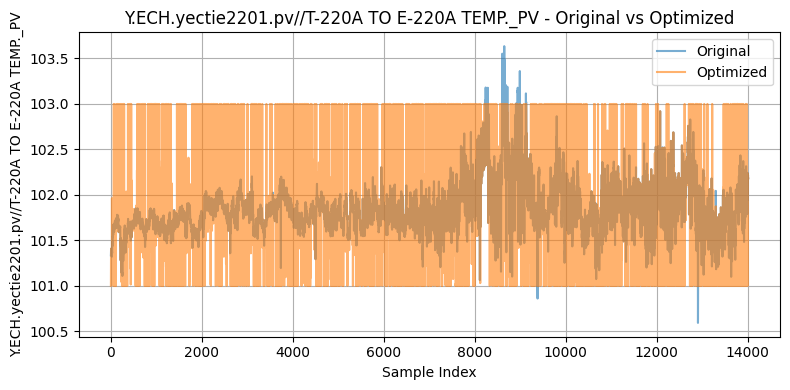

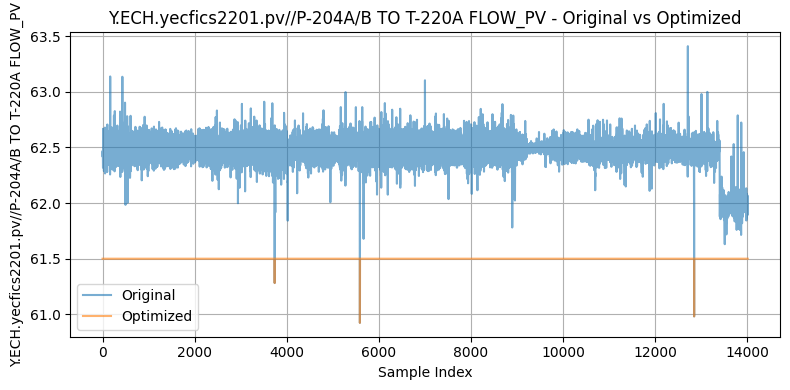

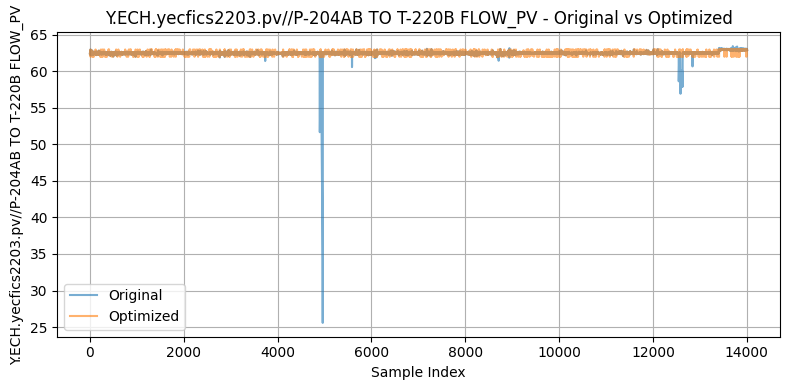

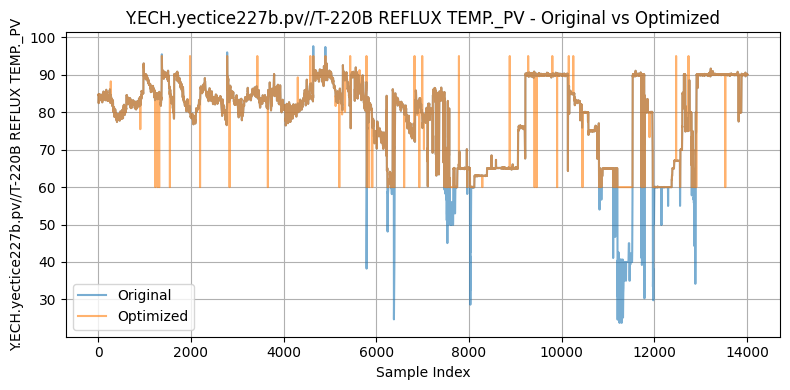

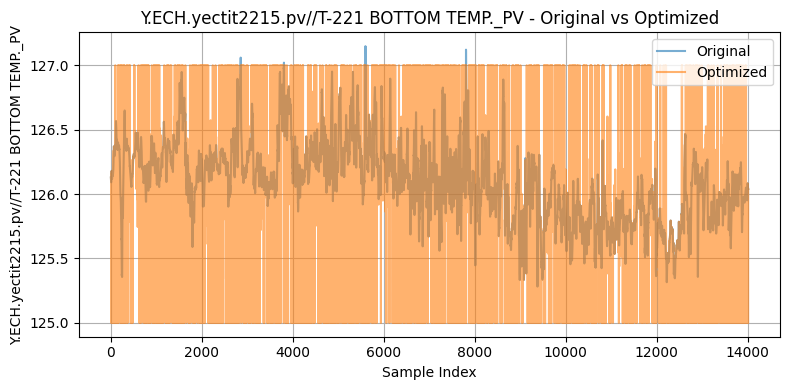

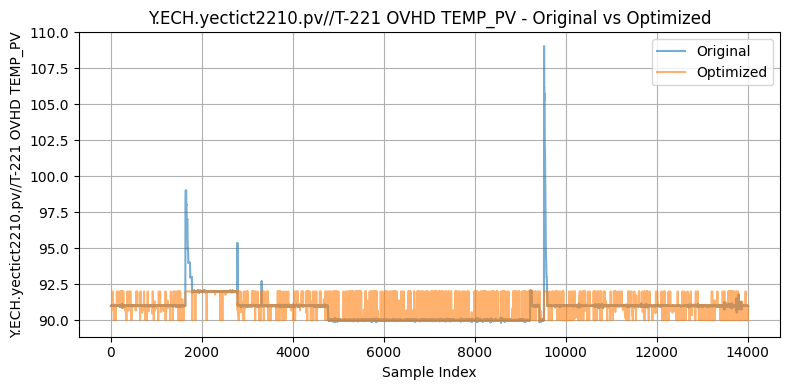

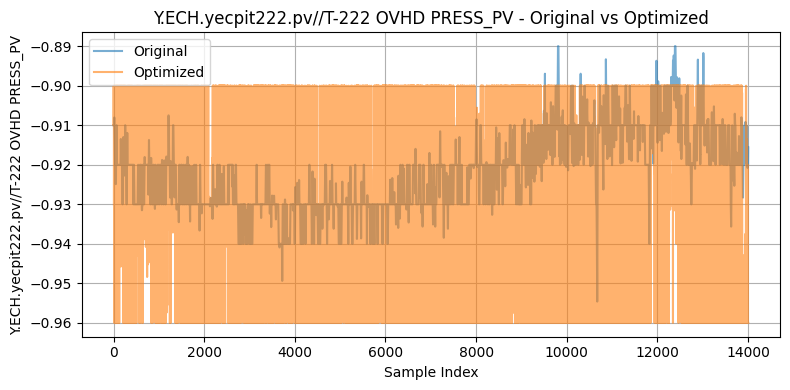

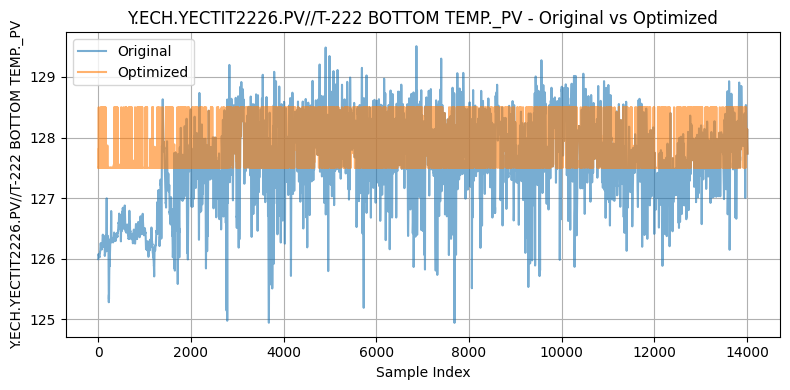

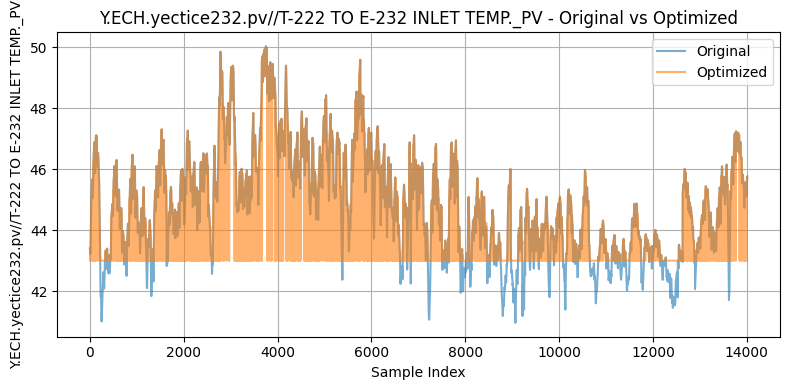

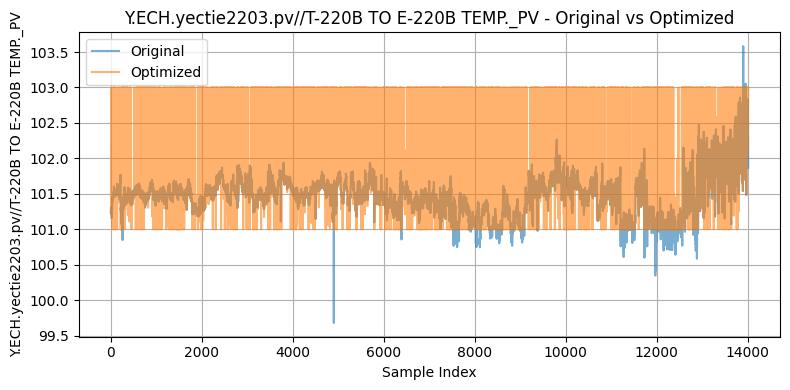

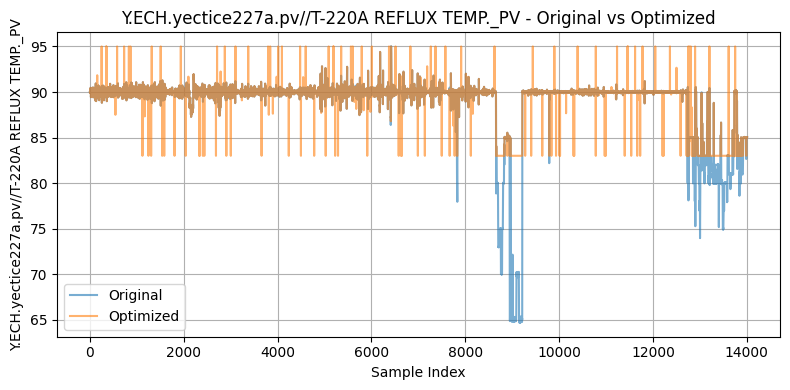

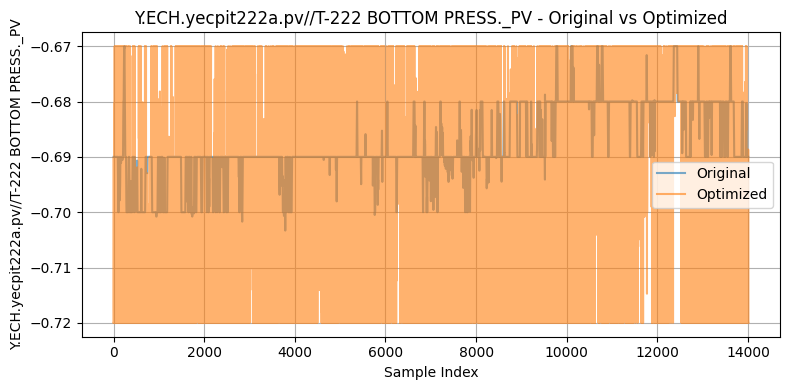

In [341]:
df_original_controls = X_all[control_indices].reset_index(drop=True)

for tag in control_indices:
    plt.figure(figsize=(8, 4))
    plt.plot(df_original_controls[tag], label='Original', alpha=0.6)
    plt.plot(df_optimized_controls[tag], label='Optimized', alpha=0.6)
    plt.title(f'{tag} - Original vs Optimized')
    plt.xlabel('Sample Index')
    plt.ylabel(tag)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_analysis = pd.concat([df_optimized_results, df_optimized_controls], axis=1)
correlation_matrix = df_analysis.corr()
yield_correlations = correlation_matrix['Optimized_Yield']
sorted_correlations = yield_correlations.drop('Optimized_Yield').sort_values(ascending=False)

print("--- Correlation between Optimized Variables and Predicted Y ---")
print(sorted_correlations)


plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(10, 8))

sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index)

plt.title("Correlation between Optimized Variables and Predicted Y", fontsize=16)
plt.xlabel("Correlation Coefficient (Higher value means greater impact on Predicted Y)", fontsize=12)
plt.ylabel("Optimized Variables", fontsize=12)

plt.tight_layout()
plt.show()